In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.insert(1, '../../yukun_disentanglement_lib/')
sys.path.insert(0, '../source_tf/utils')
sys.path.insert(0, '../source_tf/models')
from keras import metrics
import tensorflow_hub as hub
import tensorflow as tf
import yukun_disentanglement_lib
from yukun_disentanglement_lib.data.ground_truth import celeba, celebaHR
from data_helpers import DataProvider
from simgan_models import simgan_decoder, simgan_decoder_hr, simgan_discriminator, simgan_encoder
# from dsvae_model_large_HR_noY import DSVAELHR, loss_function
from dsvae_model_large_HR_noY_hr_to_hr import DSVAELHR, loss_function
import numpy as np
import time, math
from misc import merge
import argparse
import wandb
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import torch

Using TensorFlow backend.


In [2]:
log = True
if log:
    wandb.init(project="pytorch_dsvae_hr", name="celeba_dsvae_100k_no_Y_HR_HR")

# Load the data

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--z_dim", help="z dimension", default=85, type=int)
parser.add_argument("--device", help="gpu id", default=1, type=int)
parser.add_argument("--nb_epochs", help="number of epochs", default=500, type=int)
parser.add_argument("--start_epoch", help="epoch to start training from (requires checkpoints)", default=0, type=int)
parser.add_argument("--save_interval", help="epochs to save model", default=10, type=int)
parser.add_argument("--run_seed", help="run seed of TCVAE", default=100, type=int)
parser.add_argument("--lr", help="learning rate", default=.0001, type=float)
parser.add_argument("--batch_size", help="batch size", default=100, type=int)
args = parser.parse_args([])

if log:
    wandb.config.update(args)

device = args.device
print("z_dim: {}".format(args.z_dim))
print("GPU: {}".format(device))
print("start_epoch: {}".format(args.start_epoch))
print("save_interval: {}".format(args.save_interval))

#path to classifier
classifier_url = '../../tcvae_models/celeba10/train_output/d_15_b_15_{}/tfhub/'.format(0)
# classifier_url = '../../tcvae_models/celeba/train_output/100k/d_15_b_15_{}/tfhub/'.format(args.run_seed)
print("Classifier URL")
print(classifier_url)
classifier = hub.Module(classifier_url)
num_samples=100000
dta = celeba.CelebA(celeba_path="../../yukun_disentanglement_lib/img_align_celeba", num_samples=num_samples)
dtahr = celebaHR.CelebAHR(celeba_path="../../yukun_disentanglement_lib/img_align_celeba", num_samples=num_samples, res=128)

wandb: Wandb version 0.8.29 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


z_dim: 85
GPU: 1
start_epoch: 0
save_interval: 10
Classifier URL
../../tcvae_models/celeba10/train_output/d_15_b_15_0/tfhub/
100000
finish reading face images
(100000, 64, 64, 3)
100000
finish reading face images
(100000, 128, 128, 3)


In [12]:
inputs = np.float32(dta.images)
inputshr = np.float32(dtahr.images)

In [15]:
torch_inputs = torch.from_numpy(inputs).permute(0,3,1,2)
torch_inputs_hr = torch.from_numpy(inputshr).permute(0,3,1,2)
# torch_targets = torch.from_numpy(targets).permute(0,1,4,2,3)

In [4]:
# # celeba from yukun_dis_lib
# load = True
# save = True
# num_y_samples = 10
# tf.set_random_seed(1)
# if not load:
#     raw_pics = np.float32(np.empty((num_samples, num_y_samples, 64, 64,3)))
#     with hub.eval_function_for_module(classifier_url) as f:
#         for j in range(num_y_samples):
#             raw_pic = []
#             for i in range(10):
#                 real_pics = np.float32(dta.images[i*int(num_samples/10):(i+1)*int(num_samples/10)])
#                 raw_pic.append(f(dict(images=real_pics), signature="reconstructions", as_dict=True)["images"]) 
#             raw_pics[:,j] = np.float32(np.concatenate(raw_pic,axis=0))
#     inputs = np.float32(dta.images)
#     inputshr = np.float32(dtahr.images)
#     targets = np.float32(raw_pics)
#     if save:
#         np.save('data_hr128/inputs_10k_sample', inputs)
#         np.save('data_hr128/inputs_10k_sample_hr', inputshr)
#         np.save('data_hr128/targets_10k_sample', targets)     
# else:  
#     inputs = np.load('data_hr128/inputs_10k_sample.npy')
#     inputshr = np.load('data_hr128/inputs_10k_sample_hr.npy')
#     targets = np.load('data_hr128/targets_10k_sample.npy')

In [17]:
from pytorch_data_utils import DSVAE_DATA_HR_no_Y
torch_dataset = DSVAE_DATA_HR_no_Y(torch_inputs, torch_inputs_hr)
torch_data_loader = torch.utils.data.DataLoader(torch_dataset, batch_size=args.batch_size, shuffle=True)

In [18]:
def plot_pytorch_images(images, num_images=5, title=""):
    if images.is_cuda:
        images = images.detach().cpu()
    images = images.permute(0,2,3,1)
    img = np.expand_dims(images,0)
    img = merge(img[0],[1,num_images])
    fig = plt.figure(figsize=(8*max(1, num_images-2),8))
    plt.imshow(img)
    plt.gray()
    plt.title(title)
    plt.show()
    return fig

In [19]:
if args.device != -1:
    dsvae = DSVAELHR(z_dim=85, device=args.device)
    dsvae.to(device)
else:
    dsvae = DSVAELHR(z_dim=85, device=None)
optimizer = torch.optim.Adam(params=dsvae.parameters(), lr=args.lr)

# Define the DSVAE model

Training for 1500 epochs...


wandb: Wandb version 0.8.29 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


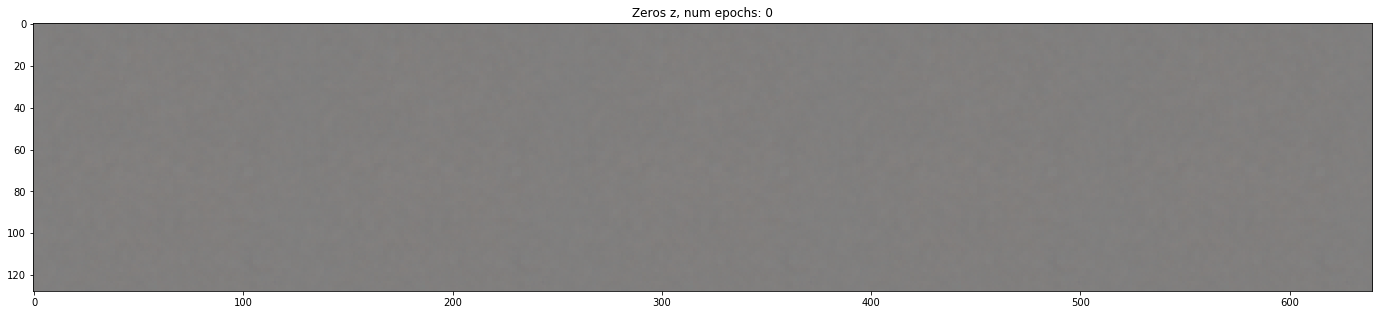

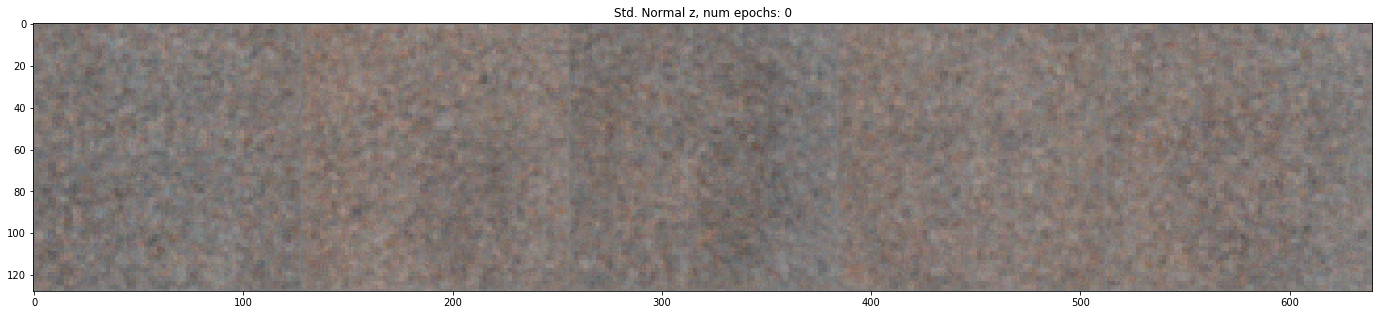

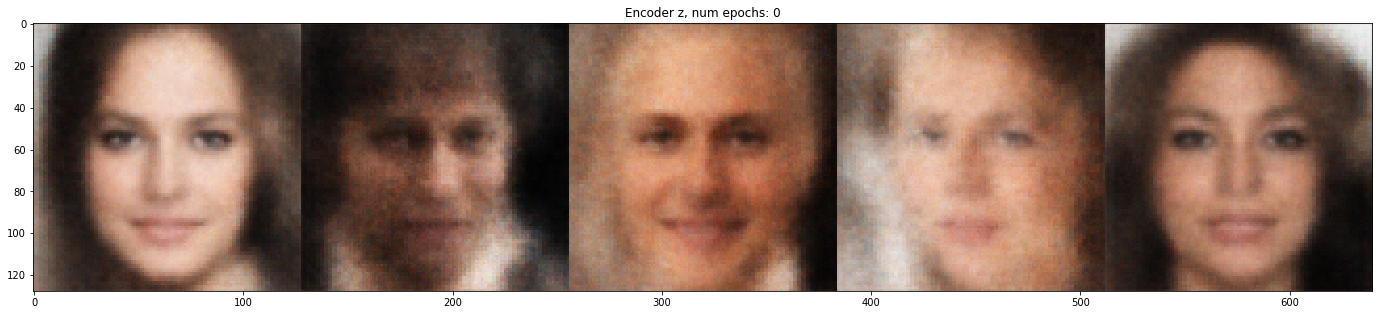

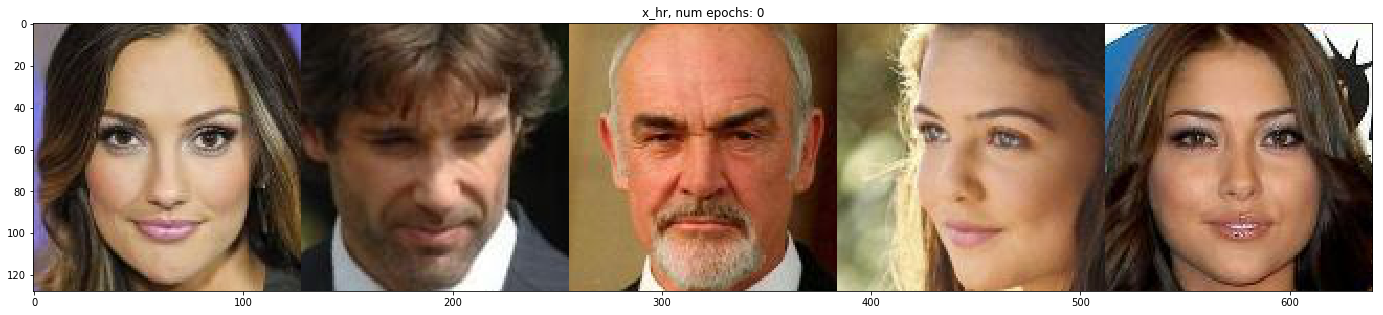

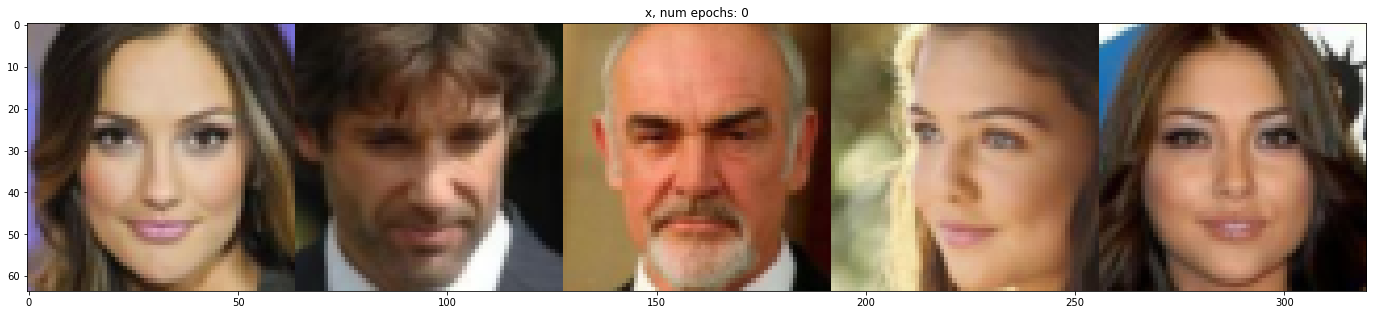

W0305 23:46:34.133851 139880709486336 util.py:575] requests_with_retry encountered retryable exception: ('Connection aborted.', OSError("(104, 'ECONNRESET')")). args: ('https://api.wandb.ai/files/churwitz/pytorch_dsvae_hr/qd59m4bd/file_stream',), kwargs: {'json': {'files': {'wandb-events.jsonl': {'offset': 448, 'content': ['{"system.gpu.0.gpu": 0.0, "system.gpu.0.memory": 0.0, "system.gpu.0.memory_allocated": 0.43, "system.gpu.0.temp": 32.0, "system.gpu.1.gpu": 79.0, "system.gpu.1.memory": 33.73, "system.gpu.1.memory_allocated": 52.39, "system.gpu.1.temp": 63.07, "system.cpu": 90.17, "system.memory": 61.2, "system.disk": 92.8, "system.proc.memory.availableMB": 46874.24, "system.proc.memory.rssMB": 72093.35, "system.proc.memory.percent": 59.65, "system.proc.cpu.threads": 58.0, "system.network.sent": 29139313, "system.network.recv": 11658851, "_wandb": true, "_timestamp": 1583451989, "_runtime": 13473}\n']}, 'wandb-history.jsonl': {'offset': 125504, 'content': ['{"loss": 25857.99609375, 

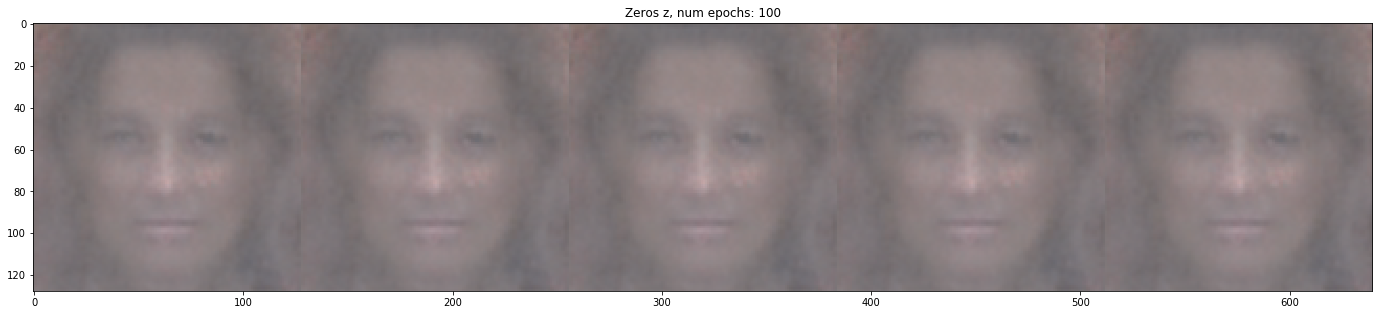

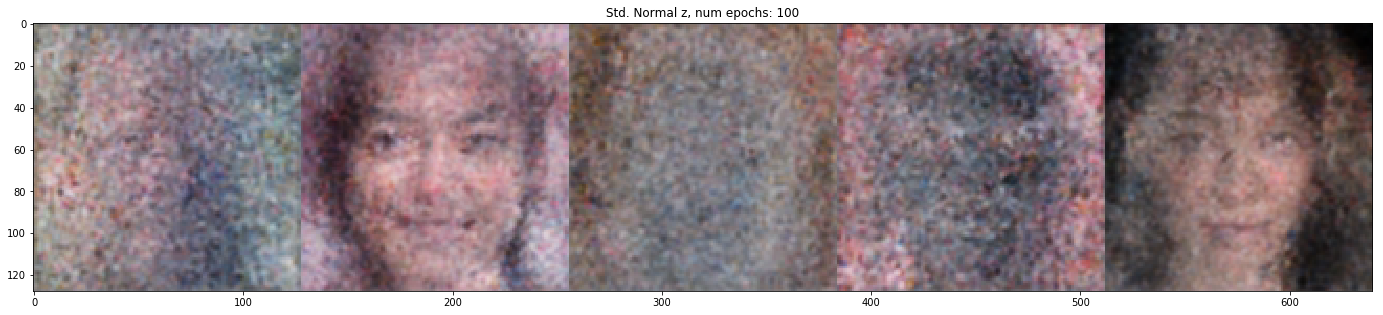

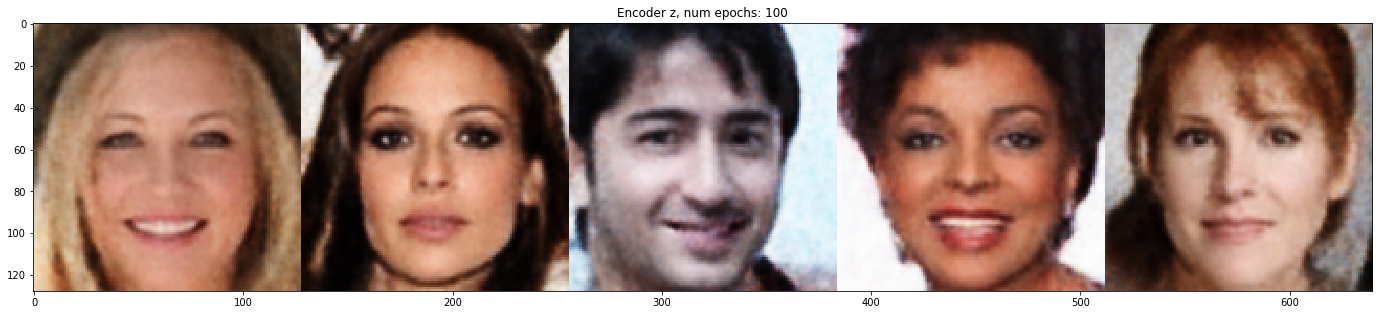

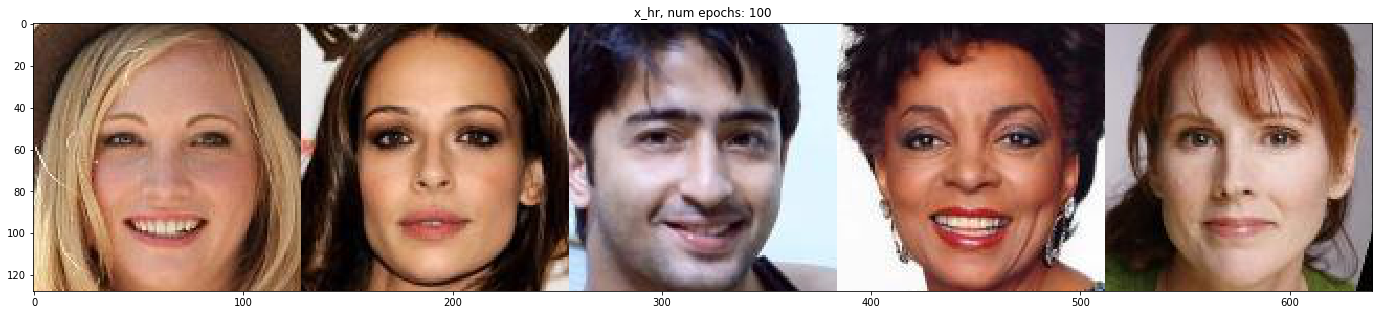

W0306 08:12:36.204965 139880709486336 util.py:575] requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/churwitz/pytorch_dsvae_hr/qd59m4bd/file_stream. args: ('https://api.wandb.ai/files/churwitz/pytorch_dsvae_hr/qd59m4bd/file_stream',), kwargs: {'json': {'files': {'wandb-events.jsonl': {'offset': 1456, 'content': ['{"system.gpu.0.gpu": 0.0, "system.gpu.0.memory": 0.0, "system.gpu.0.memory_allocated": 0.43, "system.gpu.0.temp": 32.0, "system.gpu.1.gpu": 81.13, "system.gpu.1.memory": 34.4, "system.gpu.1.memory_allocated": 52.39, "system.gpu.1.temp": 63.0, "system.cpu": 90.47, "system.memory": 61.2, "system.disk": 92.8, "system.proc.memory.availableMB": 46860.69, "system.proc.memory.rssMB": 72091.37, "system.proc.memory.percent": 59.65, "system.proc.cpu.threads": 58.0, "system.network.sent": 89695434, "system.network.recv": 26949616, "_wandb": true, "_timestamp": 1583482309, "_runtime": 43794}\n']}, 'wandb-histor

W0306 08:12:40.326265 139880709486336 util.py:575] requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/churwitz/pytorch_dsvae_hr/qd59m4bd/file_stream. args: ('https://api.wandb.ai/files/churwitz/pytorch_dsvae_hr/qd59m4bd/file_stream',), kwargs: {'json': {'files': {'wandb-events.jsonl': {'offset': 1456, 'content': ['{"system.gpu.0.gpu": 0.0, "system.gpu.0.memory": 0.0, "system.gpu.0.memory_allocated": 0.43, "system.gpu.0.temp": 32.0, "system.gpu.1.gpu": 81.13, "system.gpu.1.memory": 34.4, "system.gpu.1.memory_allocated": 52.39, "system.gpu.1.temp": 63.0, "system.cpu": 90.47, "system.memory": 61.2, "system.disk": 92.8, "system.proc.memory.availableMB": 46860.69, "system.proc.memory.rssMB": 72091.37, "system.proc.memory.percent": 59.65, "system.proc.cpu.threads": 58.0, "system.network.sent": 89695434, "system.network.recv": 26949616, "_wandb": true, "_timestamp": 1583482309, "_runtime": 43794}\n']}, 'wandb-histor

W0306 08:12:47.876222 139880709486336 util.py:575] requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/churwitz/pytorch_dsvae_hr/qd59m4bd/file_stream. args: ('https://api.wandb.ai/files/churwitz/pytorch_dsvae_hr/qd59m4bd/file_stream',), kwargs: {'json': {'files': {'wandb-events.jsonl': {'offset': 1456, 'content': ['{"system.gpu.0.gpu": 0.0, "system.gpu.0.memory": 0.0, "system.gpu.0.memory_allocated": 0.43, "system.gpu.0.temp": 32.0, "system.gpu.1.gpu": 81.13, "system.gpu.1.memory": 34.4, "system.gpu.1.memory_allocated": 52.39, "system.gpu.1.temp": 63.0, "system.cpu": 90.47, "system.memory": 61.2, "system.disk": 92.8, "system.proc.memory.availableMB": 46860.69, "system.proc.memory.rssMB": 72091.37, "system.proc.memory.percent": 59.65, "system.proc.cpu.threads": 58.0, "system.network.sent": 89695434, "system.network.recv": 26949616, "_wandb": true, "_timestamp": 1583482309, "_runtime": 43794}\n']}, 'wandb-histor

W0306 08:12:56.574479 139880709486336 util.py:575] requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/churwitz/pytorch_dsvae_hr/qd59m4bd/file_stream. args: ('https://api.wandb.ai/files/churwitz/pytorch_dsvae_hr/qd59m4bd/file_stream',), kwargs: {'json': {'files': {'wandb-events.jsonl': {'offset': 1456, 'content': ['{"system.gpu.0.gpu": 0.0, "system.gpu.0.memory": 0.0, "system.gpu.0.memory_allocated": 0.43, "system.gpu.0.temp": 32.0, "system.gpu.1.gpu": 81.13, "system.gpu.1.memory": 34.4, "system.gpu.1.memory_allocated": 52.39, "system.gpu.1.temp": 63.0, "system.cpu": 90.47, "system.memory": 61.2, "system.disk": 92.8, "system.proc.memory.availableMB": 46860.69, "system.proc.memory.rssMB": 72091.37, "system.proc.memory.percent": 59.65, "system.proc.cpu.threads": 58.0, "system.network.sent": 89695434, "system.network.recv": 26949616, "_wandb": true, "_timestamp": 1583482309, "_runtime": 43794}\n']}, 'wandb-histor

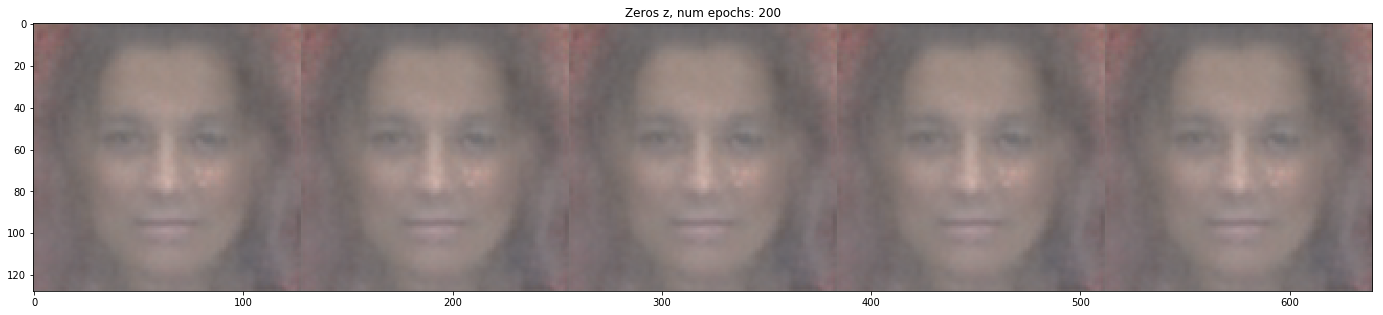

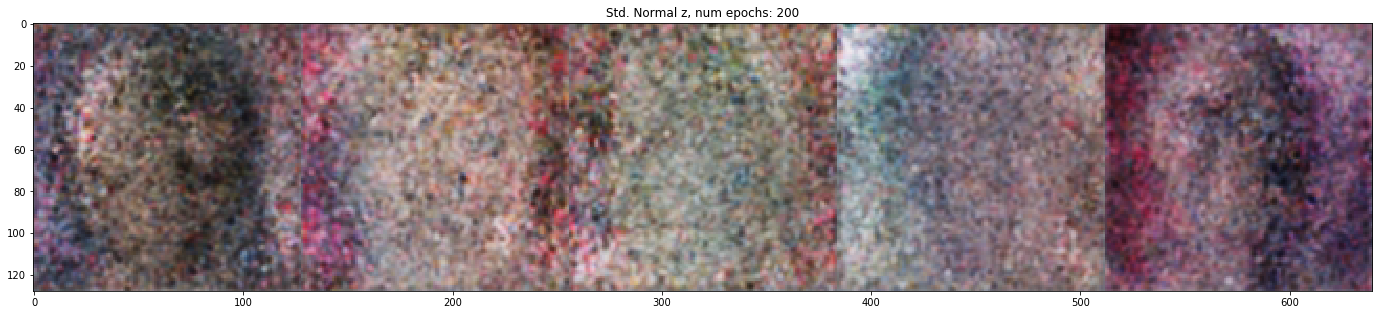

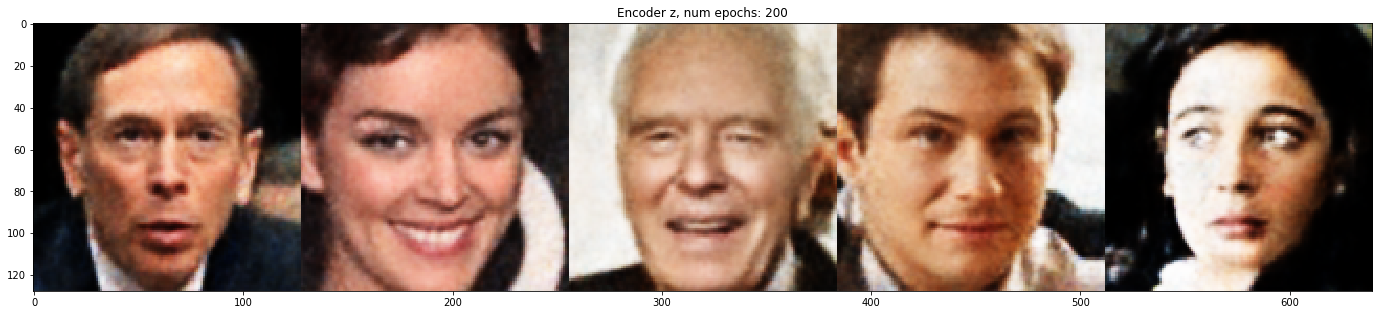

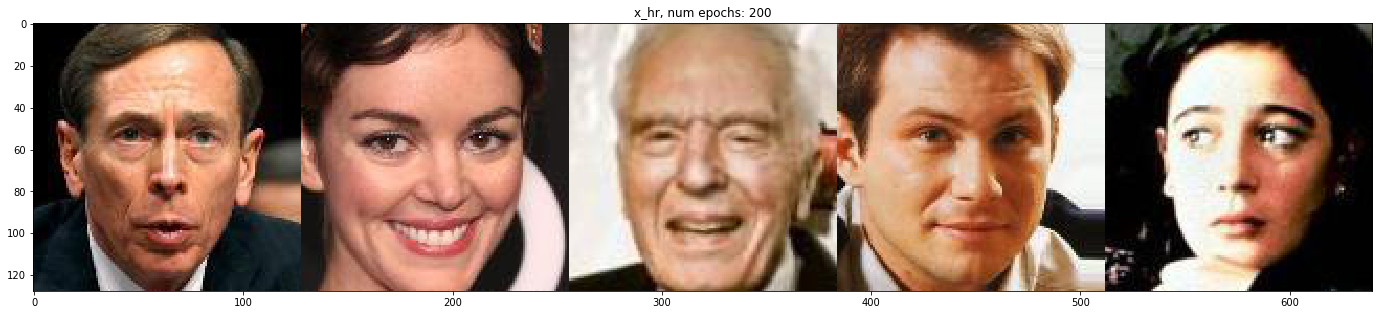

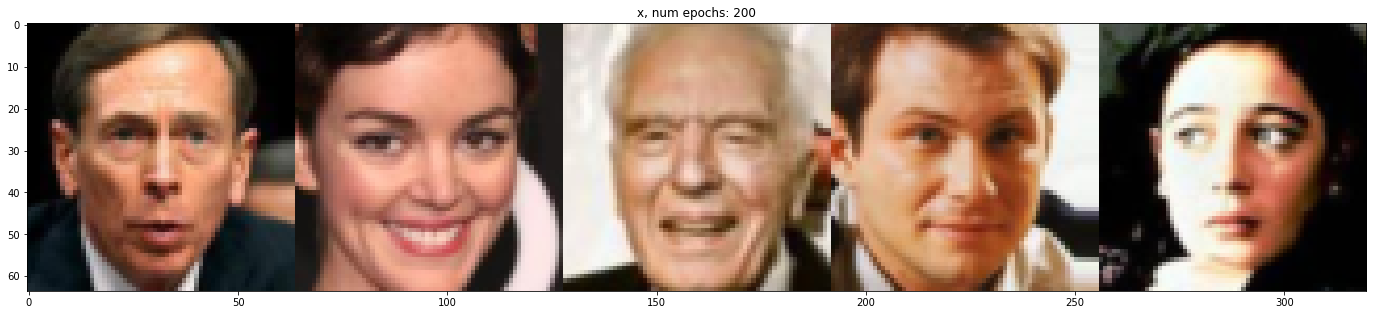

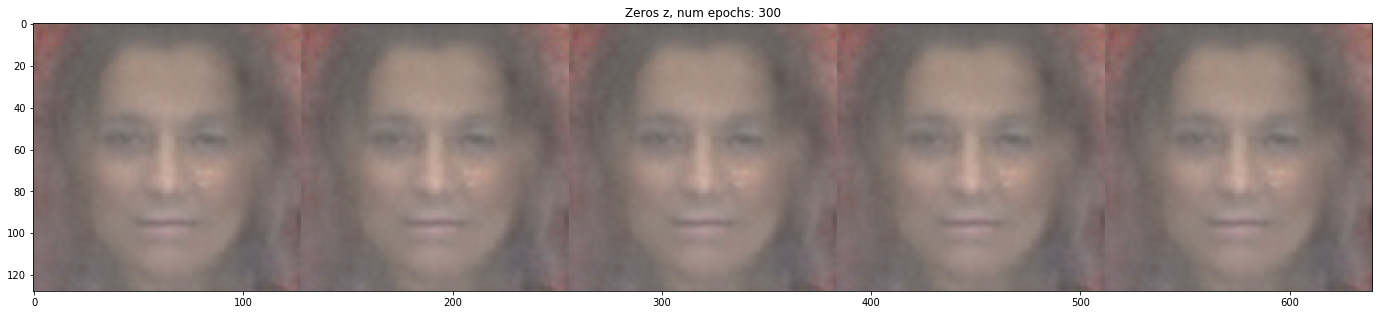

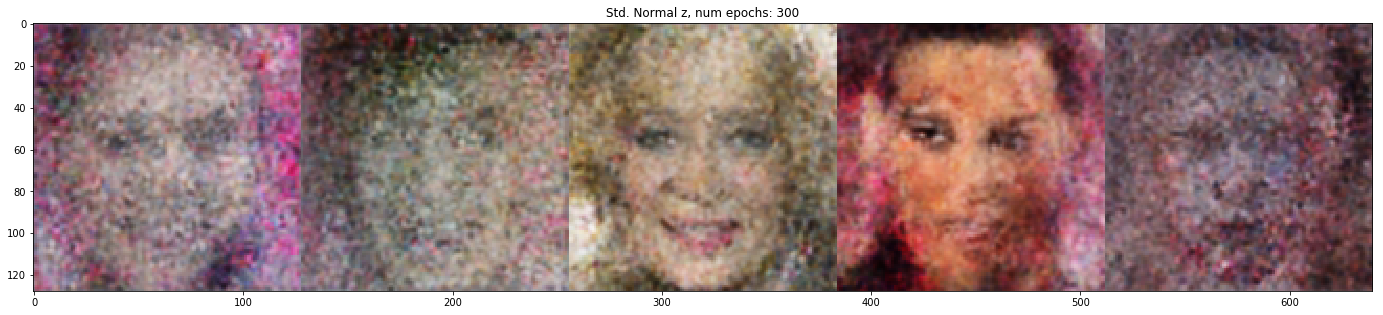

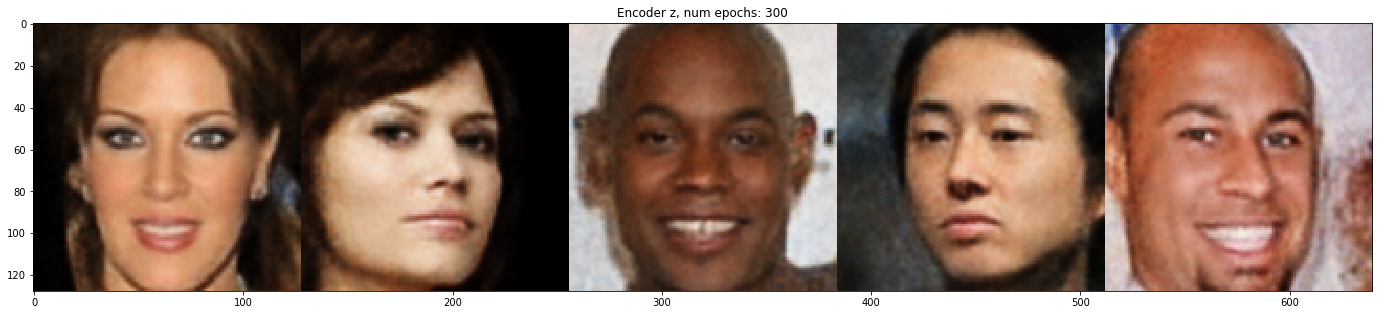

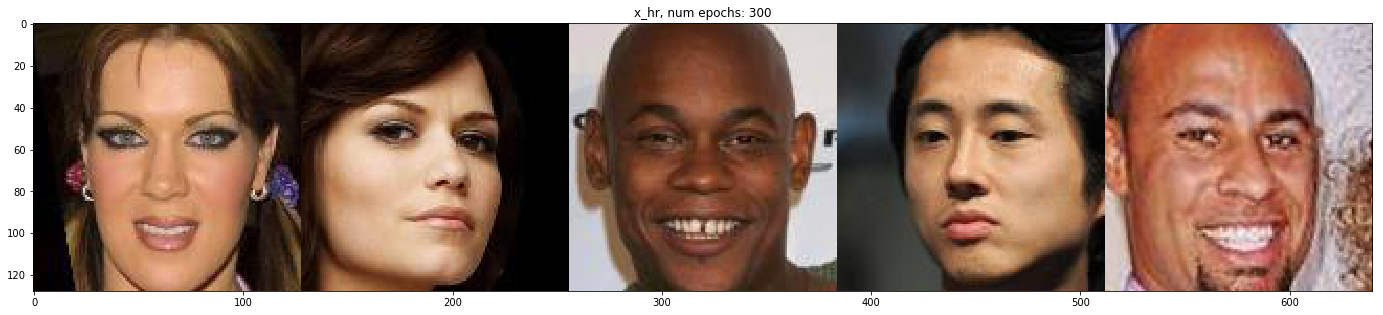

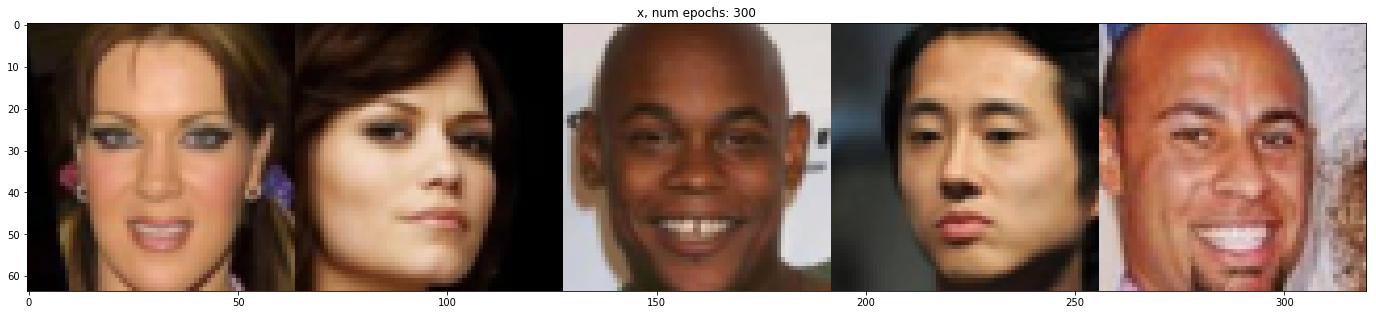

W0306 22:30:52.323767 139880709486336 util.py:575] requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/churwitz/pytorch_dsvae_hr/qd59m4bd/file_stream. args: ('https://api.wandb.ai/files/churwitz/pytorch_dsvae_hr/qd59m4bd/file_stream',), kwargs: {'json': {'files': {'wandb-events.jsonl': {'offset': 3169, 'content': ['{"system.gpu.0.gpu": 0.0, "system.gpu.0.memory": 0.0, "system.gpu.0.memory_allocated": 0.43, "system.gpu.0.temp": 32.0, "system.gpu.1.gpu": 78.27, "system.gpu.1.memory": 33.33, "system.gpu.1.memory_allocated": 52.39, "system.gpu.1.temp": 63.53, "system.cpu": 90.31, "system.memory": 61.3, "system.disk": 92.8, "system.proc.memory.availableMB": 46800.97, "system.proc.memory.rssMB": 72093.9, "system.proc.memory.percent": 59.65, "system.proc.cpu.threads": 58.0, "system.network.sent": 261655338, "system.network.recv": 196579045, "_wandb": true, "_timestamp": 1583533843, "_runtime": 95327}\n']}, 'wandb-his

W0306 22:30:56.582504 139880709486336 util.py:575] requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/churwitz/pytorch_dsvae_hr/qd59m4bd/file_stream. args: ('https://api.wandb.ai/files/churwitz/pytorch_dsvae_hr/qd59m4bd/file_stream',), kwargs: {'json': {'files': {'wandb-events.jsonl': {'offset': 3169, 'content': ['{"system.gpu.0.gpu": 0.0, "system.gpu.0.memory": 0.0, "system.gpu.0.memory_allocated": 0.43, "system.gpu.0.temp": 32.0, "system.gpu.1.gpu": 78.27, "system.gpu.1.memory": 33.33, "system.gpu.1.memory_allocated": 52.39, "system.gpu.1.temp": 63.53, "system.cpu": 90.31, "system.memory": 61.3, "system.disk": 92.8, "system.proc.memory.availableMB": 46800.97, "system.proc.memory.rssMB": 72093.9, "system.proc.memory.percent": 59.65, "system.proc.cpu.threads": 58.0, "system.network.sent": 261655338, "system.network.recv": 196579045, "_wandb": true, "_timestamp": 1583533843, "_runtime": 95327}\n']}, 'wandb-his

W0306 22:31:56.230406 139880709486336 util.py:575] requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/churwitz/pytorch_dsvae_hr/qd59m4bd/file_stream. args: ('https://api.wandb.ai/files/churwitz/pytorch_dsvae_hr/qd59m4bd/file_stream',), kwargs: {'json': {'files': {'wandb-events.jsonl': {'offset': 3169, 'content': ['{"system.gpu.0.gpu": 0.0, "system.gpu.0.memory": 0.0, "system.gpu.0.memory_allocated": 0.43, "system.gpu.0.temp": 32.0, "system.gpu.1.gpu": 78.27, "system.gpu.1.memory": 33.33, "system.gpu.1.memory_allocated": 52.39, "system.gpu.1.temp": 63.53, "system.cpu": 90.31, "system.memory": 61.3, "system.disk": 92.8, "system.proc.memory.availableMB": 46800.97, "system.proc.memory.rssMB": 72093.9, "system.proc.memory.percent": 59.65, "system.proc.cpu.threads": 58.0, "system.network.sent": 261655338, "system.network.recv": 196579045, "_wandb": true, "_timestamp": 1583533843, "_runtime": 95327}\n']}, 'wandb-his

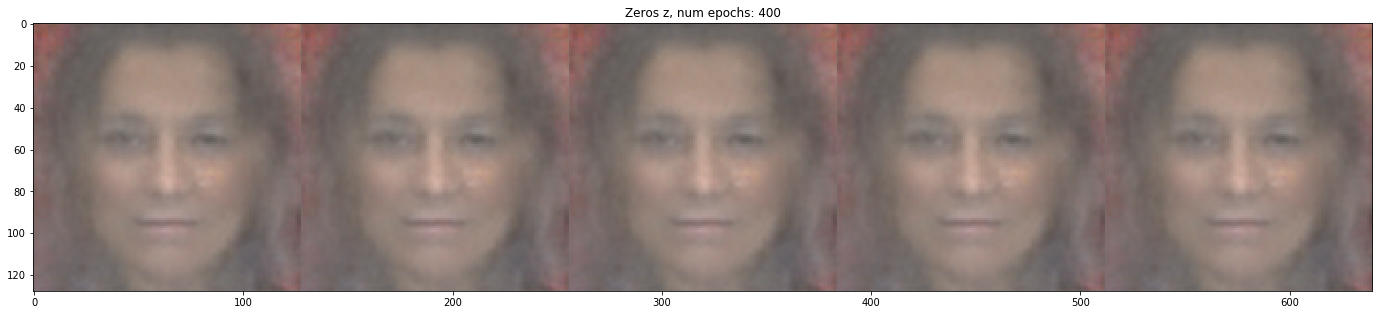

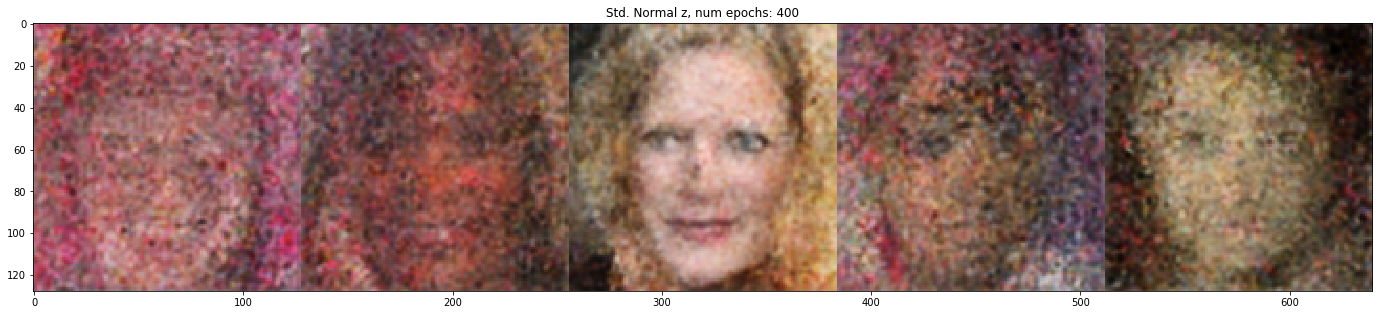

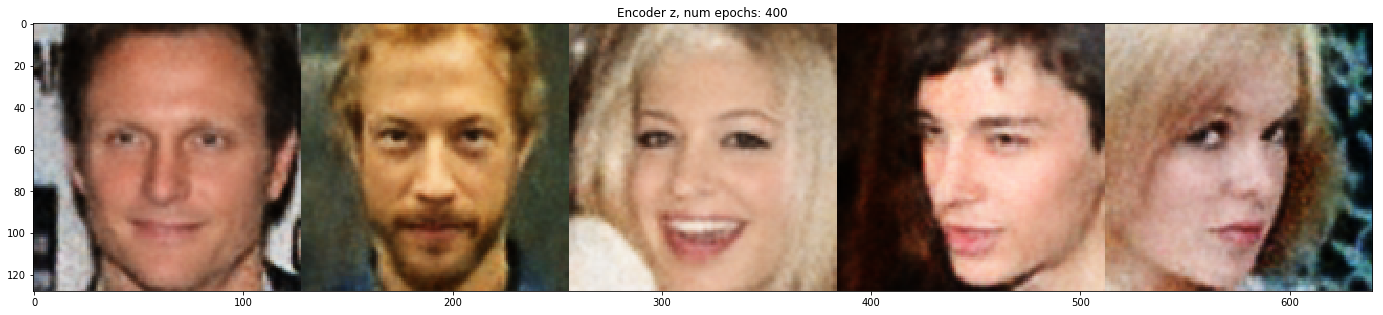

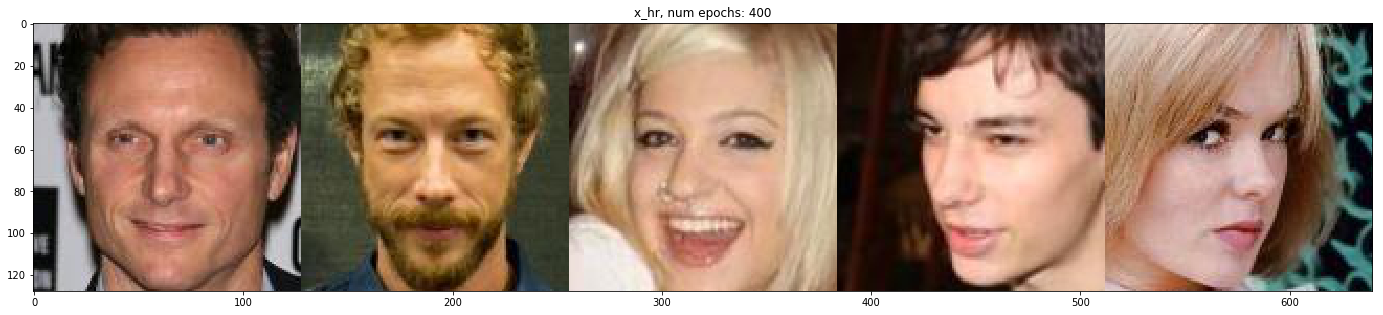

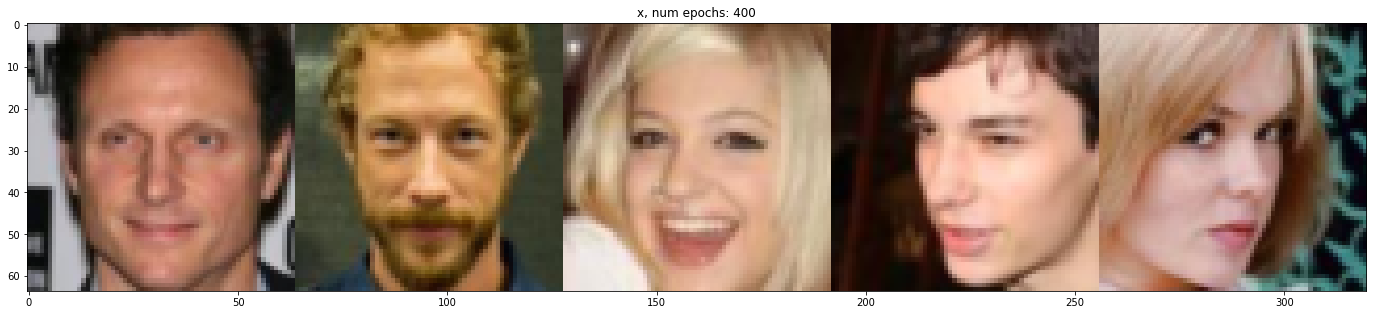

W0307 07:56:26.929095 139880709486336 util.py:575] requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/churwitz/pytorch_dsvae_hr/qd59m4bd/file_stream. args: ('https://api.wandb.ai/files/churwitz/pytorch_dsvae_hr/qd59m4bd/file_stream',), kwargs: {'json': {'files': {'wandb-events.jsonl': {'offset': 4295, 'content': ['{"system.gpu.0.gpu": 0.0, "system.gpu.0.memory": 0.0, "system.gpu.0.memory_allocated": 0.43, "system.gpu.0.temp": 31.73, "system.gpu.1.gpu": 80.6, "system.gpu.1.memory": 35.0, "system.gpu.1.memory_allocated": 52.39, "system.gpu.1.temp": 63.2, "system.cpu": 90.35, "system.memory": 61.3, "system.disk": 92.8, "system.proc.memory.availableMB": 46785.18, "system.proc.memory.rssMB": 72093.24, "system.proc.memory.percent": 59.65, "system.proc.cpu.threads": 58.0, "system.network.sent": 329578799, "system.network.recv": 210237461, "_wandb": true, "_timestamp": 1583567713, "_runtime": 129197}\n']}, 'wandb-his

W0307 07:56:29.214474 139880709486336 util.py:575] requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/churwitz/pytorch_dsvae_hr/qd59m4bd/file_stream. args: ('https://api.wandb.ai/files/churwitz/pytorch_dsvae_hr/qd59m4bd/file_stream',), kwargs: {'json': {'files': {'wandb-events.jsonl': {'offset': 4295, 'content': ['{"system.gpu.0.gpu": 0.0, "system.gpu.0.memory": 0.0, "system.gpu.0.memory_allocated": 0.43, "system.gpu.0.temp": 31.73, "system.gpu.1.gpu": 80.6, "system.gpu.1.memory": 35.0, "system.gpu.1.memory_allocated": 52.39, "system.gpu.1.temp": 63.2, "system.cpu": 90.35, "system.memory": 61.3, "system.disk": 92.8, "system.proc.memory.availableMB": 46785.18, "system.proc.memory.rssMB": 72093.24, "system.proc.memory.percent": 59.65, "system.proc.cpu.threads": 58.0, "system.network.sent": 329578799, "system.network.recv": 210237461, "_wandb": true, "_timestamp": 1583567713, "_runtime": 129197}\n']}, 'wandb-his

W0307 07:56:33.827857 139880709486336 util.py:575] requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/churwitz/pytorch_dsvae_hr/qd59m4bd/file_stream. args: ('https://api.wandb.ai/files/churwitz/pytorch_dsvae_hr/qd59m4bd/file_stream',), kwargs: {'json': {'files': {'wandb-events.jsonl': {'offset': 4295, 'content': ['{"system.gpu.0.gpu": 0.0, "system.gpu.0.memory": 0.0, "system.gpu.0.memory_allocated": 0.43, "system.gpu.0.temp": 31.73, "system.gpu.1.gpu": 80.6, "system.gpu.1.memory": 35.0, "system.gpu.1.memory_allocated": 52.39, "system.gpu.1.temp": 63.2, "system.cpu": 90.35, "system.memory": 61.3, "system.disk": 92.8, "system.proc.memory.availableMB": 46785.18, "system.proc.memory.rssMB": 72093.24, "system.proc.memory.percent": 59.65, "system.proc.cpu.threads": 58.0, "system.network.sent": 329578799, "system.network.recv": 210237461, "_wandb": true, "_timestamp": 1583567713, "_runtime": 129197}\n']}, 'wandb-his

W0307 07:57:12.839977 139880709486336 util.py:575] requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/churwitz/pytorch_dsvae_hr/qd59m4bd/file_stream. args: ('https://api.wandb.ai/files/churwitz/pytorch_dsvae_hr/qd59m4bd/file_stream',), kwargs: {'json': {'files': {'wandb-events.jsonl': {'offset': 4295, 'content': ['{"system.gpu.0.gpu": 0.0, "system.gpu.0.memory": 0.0, "system.gpu.0.memory_allocated": 0.43, "system.gpu.0.temp": 31.73, "system.gpu.1.gpu": 80.6, "system.gpu.1.memory": 35.0, "system.gpu.1.memory_allocated": 52.39, "system.gpu.1.temp": 63.2, "system.cpu": 90.35, "system.memory": 61.3, "system.disk": 92.8, "system.proc.memory.availableMB": 46785.18, "system.proc.memory.rssMB": 72093.24, "system.proc.memory.percent": 59.65, "system.proc.cpu.threads": 58.0, "system.network.sent": 329578799, "system.network.recv": 210237461, "_wandb": true, "_timestamp": 1583567713, "_runtime": 129197}\n']}, 'wandb-his

W0307 07:57:29.417947 139880709486336 util.py:575] requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/churwitz/pytorch_dsvae_hr/qd59m4bd/file_stream. args: ('https://api.wandb.ai/files/churwitz/pytorch_dsvae_hr/qd59m4bd/file_stream',), kwargs: {'json': {'files': {'wandb-events.jsonl': {'offset': 4295, 'content': ['{"system.gpu.0.gpu": 0.0, "system.gpu.0.memory": 0.0, "system.gpu.0.memory_allocated": 0.43, "system.gpu.0.temp": 31.73, "system.gpu.1.gpu": 80.6, "system.gpu.1.memory": 35.0, "system.gpu.1.memory_allocated": 52.39, "system.gpu.1.temp": 63.2, "system.cpu": 90.35, "system.memory": 61.3, "system.disk": 92.8, "system.proc.memory.availableMB": 46785.18, "system.proc.memory.rssMB": 72093.24, "system.proc.memory.percent": 59.65, "system.proc.cpu.threads": 58.0, "system.network.sent": 329578799, "system.network.recv": 210237461, "_wandb": true, "_timestamp": 1583567713, "_runtime": 129197}\n']}, 'wandb-his

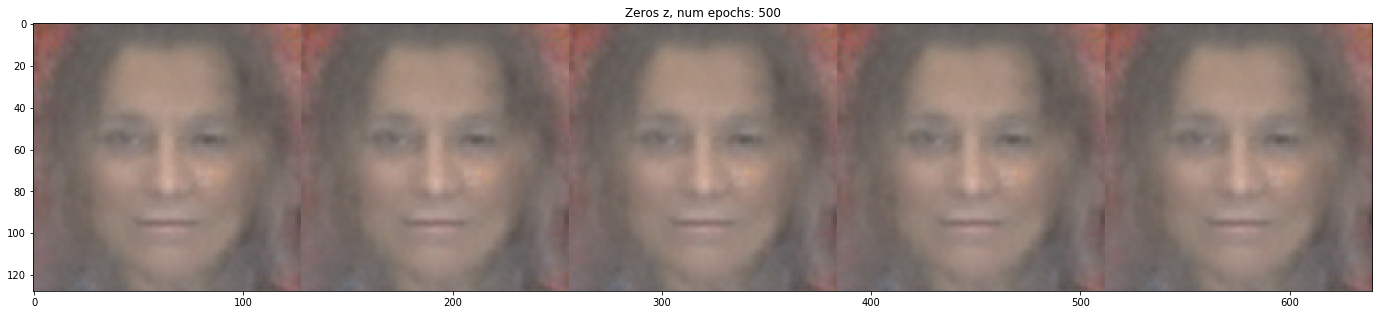

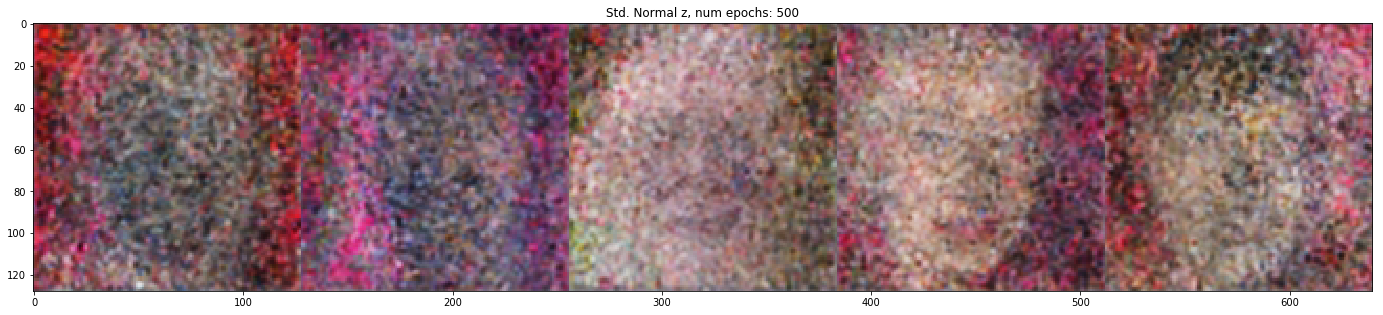

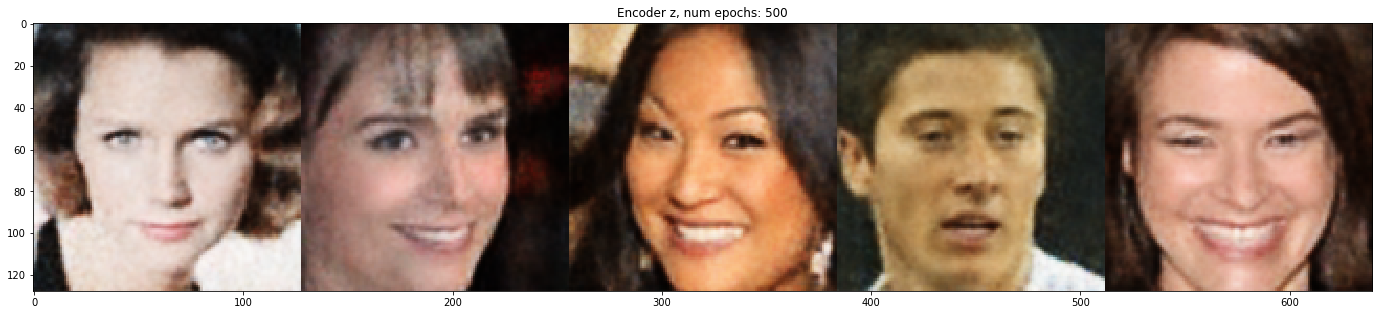

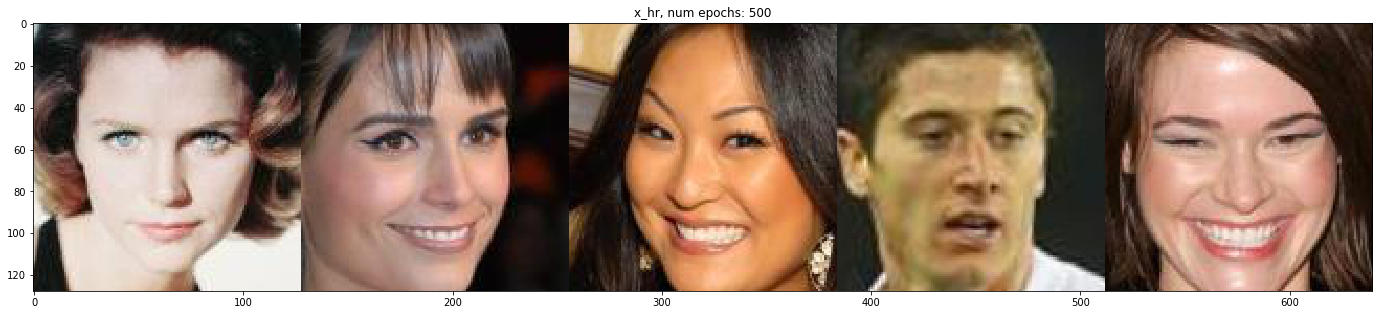

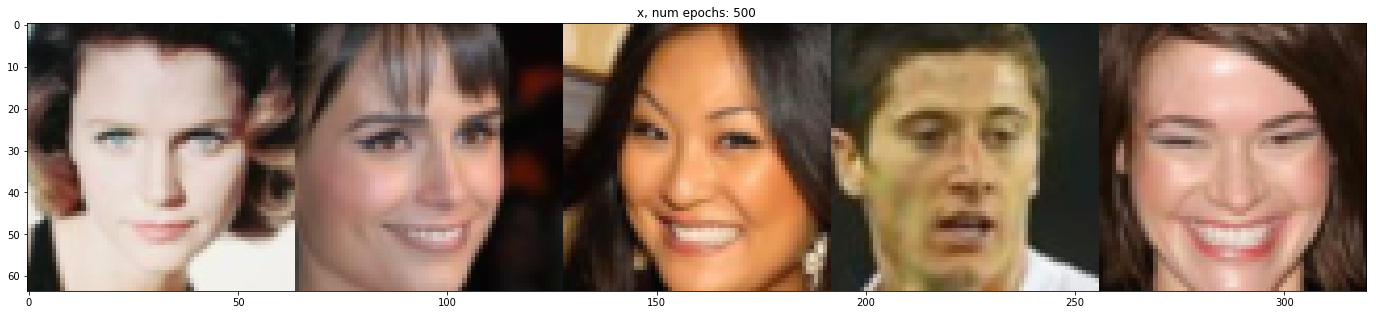

KeyboardInterrupt: 

In [20]:
dsvae.train()
normal = torch.distributions.Normal(0,1)
print("Training for {} epochs...".format(1500))
for n in range(0, 1500):
    for (i, X) in enumerate(torch_data_loader):
        x = X[0]
        x_hr = X[1]
        if dsvae.cuda:
            x = x.to(device)
            x_hr = x_hr.to(device)
        optimizer.zero_grad()
        x_hr_hat, z_mu, z_var = dsvae(x_hr)
        loss, recon_loss, kl_loss = loss_function(x_hr_hat, x_hr, z_mu, z_var)
        if log:
            wandb.log({'loss':loss})
            wandb.log({'recon_loss':recon_loss})
            wandb.log({'kl_loss':kl_loss})
        loss.backward()
        optimizer.step()

    if n%100 ==0:
        dsvae.eval() #evaluate model
        z_noise = normal.sample((x_hr.shape[0],85))
        noise = normal.sample(x_hr.shape)
        z_zeros = torch.zeros((x_hr.shape[0],85))
        
        if dsvae.cuda:
            z_noise = z_noise.to(device)
            z_zeros = z_zeros.to(device)
            noise = noise.to(device)
        x_hat_noise = dsvae.decode(noise,z_noise)
        x_hat_zeros = dsvae.decode(noise,z_zeros)
        
        fig = plot_pytorch_images(x_hat_zeros[:5], num_images=5, title='Zeros z, num epochs: {}'.format(n))
        if log:
            wandb.log({'Zeros z':fig})
            
        fig = plot_pytorch_images(x_hat_noise[:5], num_images=5, title='Std. Normal z, num epochs: {}'.format(n))
        if log:
            wandb.log({'Std. Normal z':fig})
            
        fig = plot_pytorch_images(x_hr_hat[:5], num_images=5, title='Encoder z, num epochs: {}'.format(n))
        if log:
            wandb.log({'Encoder z':fig})
            
        fig = plot_pytorch_images(x_hr[:5], num_images=5, title='x_hr, num epochs: {}'.format(n))
        if log:
            wandb.log({'x_hr':fig})
            
        fig = plot_pytorch_images(x[:5], num_images=5, title='x, num epochs: {}'.format(n))
        if log:
            wandb.log({'x':fig})

#         fig = plot_pytorch_images(torch.sigmoid(y[:5]), num_images=5, title='y, num epochs: {}'.format(n))
#         if log:
#             wandb.log({'y':fig})   
        dsvae.train() #back to training model

In [21]:
torch.save(dsvae, 'dsvae_100k_y_gauss')

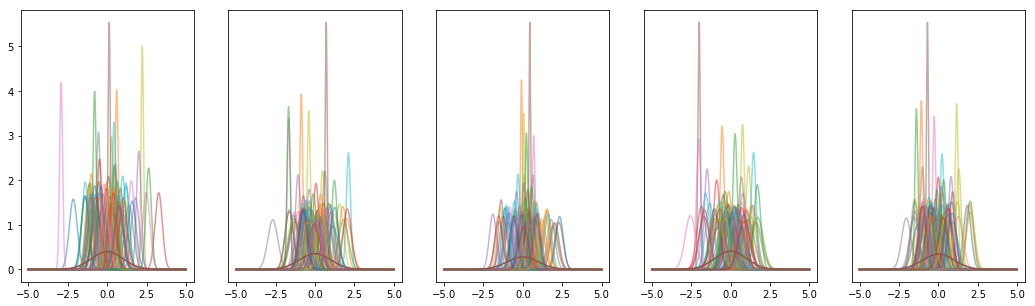

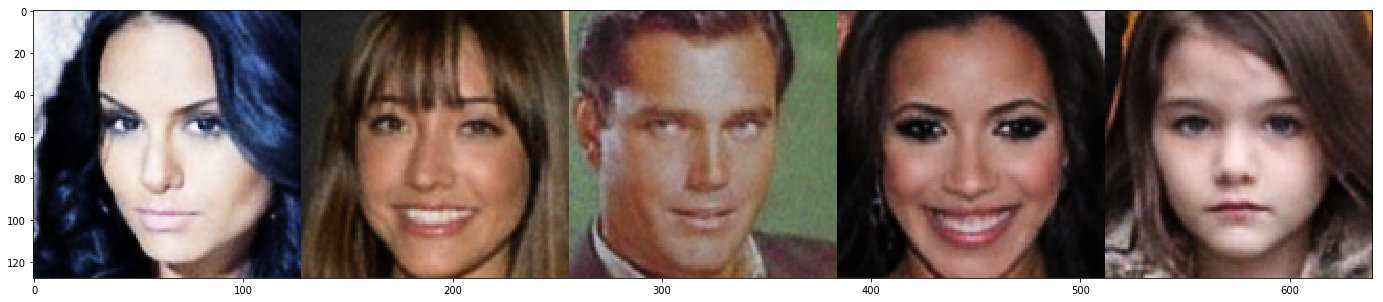

In [16]:
dsvae.eval()
# plot_pytorch_images(torch_dataset[0:5][1], num_images=5)
x_hat, z_mu, z_var = dsvae(torch_dataset[0:5][1].to(device))
# plot_pytorch_images(x_hat, num_images=5);

from scipy.stats import norm
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(18,5))
idx = 4
x_axis = np.arange(-5, 5, 0.001)
for idx in range(0,5):
    ax = axes[idx]
    for i, mu in enumerate(z_mu[idx]):
        ax.plot(x_axis, norm.pdf(x_axis, mu.detach().cpu().numpy(), torch.sqrt(z_var[idx][i]).detach().cpu().numpy()), alpha=.5)
    ax.plot(x_axis, norm.pdf(x_axis, 0,1))
    if idx > 0:
        ax.set_yticks([],[])
plt.show()
plot_pytorch_images(x_hat, num_images=5);

In [54]:
torch.distributions.Normal(z_mu, z_var).sample().shape

torch.Size([100, 85])

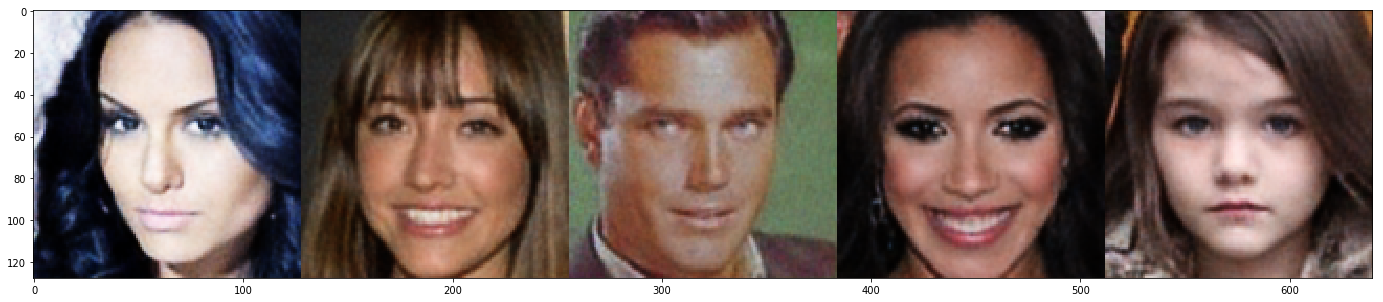

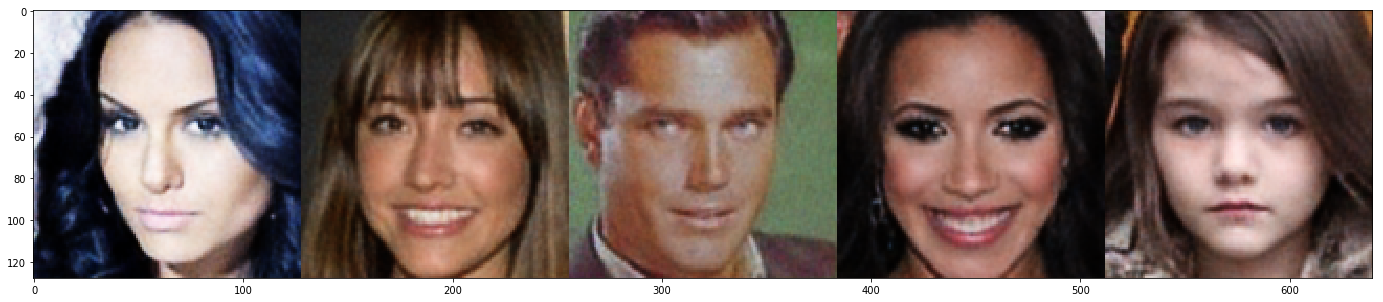

In [55]:
dsvae.eval()
# plot_pytorch_images(torch_dataset[0:5][1], num_images=5)
x_hat, z_mu, z_var = dsvae(torch_dataset[0:5][1].to(device))
plot_pytorch_images(x_hat, num_images=5);
noise = torch.distributions.Normal(0, 1).sample((5,3,128,128)).to(device)
x_hat_sample = dsvae.decode(noise, torch.distributions.Normal(z_mu, z_var).sample())
plot_pytorch_images(x_hat, num_images=5);

In [65]:
torch.var(z_mu, 0).shape

torch.Size([85])

In [90]:
torch.cuda.empty_cache()

In [117]:
dsvae.eval()
dsvae.cpu()
dsvae.device = None
x_hr_hat, z_mu, z_var = dsvae(torch_dataset[:1000][1])
z_sample = torch.distributions.Normal(z_mu, z_var).sample()
z_sample_avg = torch.mean(z_sample, 0)
z_sample_std = torch.std(z_sample, 0)

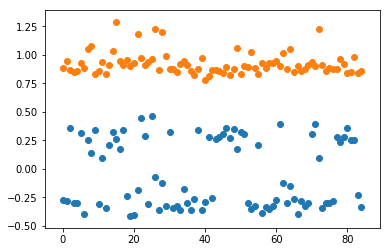

In [130]:
plt.scatter(range(85), z_sample_avg.detach().cpu().numpy())
plt.scatter(range(85), z_sample_std.detach().cpu().numpy())

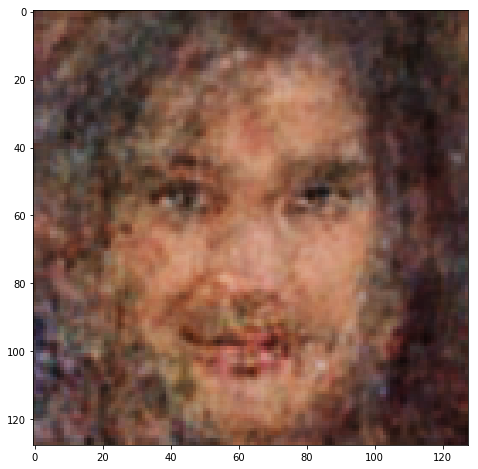

In [195]:
mu = z_sample_avg.detach()
std = z_sample_std.detach()

x_hat = dsvae.decode(torch.distributions.Normal(0,1).sample((1,3,128,128)), torch.distributions.Normal(mu, std).sample())
plot_pytorch_images(x_hat.to(device), num_images=1);

tensor(0.0213)


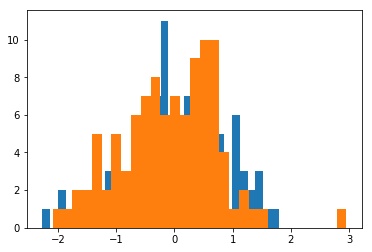

In [153]:
plt.hist(torch.distributions.Normal(0,1).sample((1,100))[0],bins=30)
mu = torch.mean(z_sample_avg).detach().cpu()
std = torch.mean(z_sample_std.detach()).cpu()
plt.hist(torch.distributions.Normal(mu,var).sample((1,100))[0], bins=30);
print(torch.distributions.kl_divergence(torch.distributions.Normal(mu,var), torch.distributions.Normal(0,1)))

In [104]:
x_axis = np.arange(-5, 5, 0.001)
ax.plot(x_axis, norm.pdf(x_axis, z_sample_avg.detach().cpu().numpy(), torch.sqrt(z_sample_std).detach().cpu().numpy()), alpha=.5)
ax.plot(x_axis, norm.pdf(x_axis, 0,1))

ValueError: operands could not be broadcast together with shapes (10000,) (85,) 

In [69]:
x_axis = np.arange(-5, 5, 0.001)
ax.plot(x_axis, norm.pdf(x_axis, mu.detach().cpu().numpy(), torch.sqrt(z_var[idx][i]).detach().cpu().numpy()), alpha=.5)
    ax.plot(x_axis, norm.pdf(x_axis, 0,1))
    if idx > 0:

IndentationError: unexpected indent (<ipython-input-69-52d14e32d2f1>, line 3)

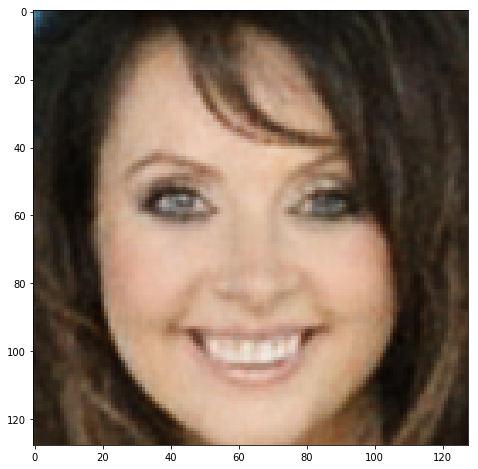

In [43]:
from IPython.display import clear_output
# z = torch.distributions.Normal(2,4).sample((1,85)).to(device)
# z = torch.distributions.Normal(z_mu[2],z_var[2]).sample().to(device)
for z in np.linspace(z_mu[99].detach().cpu().numpy(),z_mu[77].detach().cpu().numpy()):
    clear_output(wait=True)
    z = torch.from_numpy(z).unsqueeze(0).to(device)
#     z = torch.zeros((1,85)).to(device) - i
    x_hat = dsvae.decode(torch.distributions.Normal(0,1).sample((1,3,128,128)).to(device), z)
    plot_pytorch_images(x_hat, num_images=1);

In [129]:
x_hat = dsvae.decode(torch.distributions.Normal(0,1).sample((1,3,128,128)), torch.distributions.Normal(mu,var))
plot_pytorch_images(x_hat, num_images=1);

AttributeError: 'Normal' object has no attribute 'dim'

(array([  1.,   0.,   2.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   1.,
          3.,   2.,   3.,   2.,   3.,   3.,   7.,   5.,   6.,   9.,  15.,
          8.,  13.,  20.,  32.,  35.,  40.,  52.,  59.,  62.,  66.,  79.,
         93., 104., 102., 140., 124., 161., 171., 180., 172., 210., 211.,
        225., 257., 252., 217., 281., 250., 289., 264., 266., 258., 307.,
        261., 249., 258., 210., 241., 233., 198., 193., 164., 176., 156.,
        143., 116., 113., 116.,  74.,  88.,  69.,  68.,  52.,  35.,  39.,
         33.,  23.,  17.,  23.,  15.,  15.,  12.,  10.,   7.,   5.,   5.,
          3.,   3.,   3.,   5.,   1.,   1.,   1.,   0.,   1.,   0.,   0.,
          1.]),
 array([-4.2144156e+00, -4.1333251e+00, -4.0522351e+00, -3.9711447e+00,
        -3.8900542e+00, -3.8089640e+00, -3.7278736e+00, -3.6467834e+00,
        -3.5656929e+00, -3.4846027e+00, -3.4035125e+00, -3.3224220e+00,
        -3.2413318e+00, -3.1602414e+00, -3.0791512e+00, -2.9980607e+00,
        -2.9169705e+00, -2.835

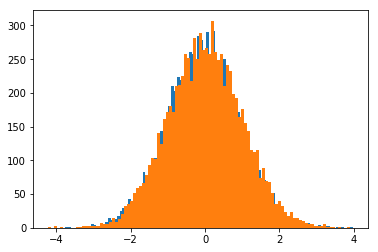

In [29]:
dsvae.eval()
# plot_pytorch_images(torch_dataset[0:5][1], num_images=5)
x_hat, z_mu, z_var = dsvae(torch_dataset[0:100][1].to(device))
# plot_pytorch_images(x_hat, num_images=5);
plt.hist(z_mu.flatten().cpu().detach().numpy(), bins=100)
plt.hist(torch.distributions.Normal(0,1).sample((1, 85*100))[0], bins=100)

In [27]:

torch.distributions.Normal(0,1).sample((1, 85*100))[0]

tensor([-0.6553, -0.4910, -1.4471,  ...,  0.7002,  0.6715,  0.7655])

In [23]:

plt.hist(torch.distributions.Normal(0,1).sample(1000), bins=100)

TypeError: 'int' object is not iterable

# Do traversals

In [10]:
# import numbers
# import os
# from yukun_disentanglement_lib.data.ground_truth import named_data
# from yukun_disentanglement_lib.utils import results
# from yukun_disentanglement_lib.visualize import visualize_util
# from yukun_disentanglement_lib.visualize.visualize_irs import vis_all_interventional_effects
# import numpy as np
# from scipy import stats
# from six.moves import range
# from tensorflow import gfile
# import gin.tf
# from yukun_disentanglement_lib.visualize.visualize_model import latent_traversal_1d_multi_dim, sigmoid, tanh

# dataname = sys.argv[1]
# output_dir = 'visualize_output_sample'
# print(output_dir)
# dlib_model_path = '/hdd/dsvae/tcvae_models/celeba10/train_output/d_15_b_15_{}/'.format(0)
# model_dir = os.path.join(dlib_model_path, '')
# overwrite=True
# num_animations=5
# num_frames=32
# fps=10
# num_points_irs=10000
# random_state = np.random.RandomState(2)
# # Create the output directory if necessary.
# if tf.gfile.IsDirectory(output_dir):
#     if overwrite:
#         tf.gfile.DeleteRecursively(output_dir)
#     else:
#         raise ValueError("Directory already exists and overwrite is False.")

# gin_config_file = os.path.join(model_dir, "results", "gin", "train.gin")
# print(gin_config_file)
# gin_dict = results.gin_dict(gin_config_file)
# dataname = gin_dict["dataset.name"]
# # Automatically infer the activation function from gin config.
# activation_str = gin_dict["reconstruction_loss.activation"]
# if activation_str == "'logits'":
#     activation = sigmoid
# elif activation_str == "'tanh'":
#     activation = tanh
# else:
#     raise ValueError(
#         "Activation function  could not be infered from gin config.")

# dataset = dta
    
# num_pics = 32
# module_path = os.path.join(model_dir, "tfhub")
# with hub.eval_function_for_module(module_path) as f:
# # Save reconstructions.
#     real_pics = dataset.sample_observations(num_pics, random_state)
#     raw_pics = f(dict(images=real_pics), signature="reconstructions", as_dict=True)["images"]
#     pics = activation(raw_pics)
    
# #     latent_noise_batch = np.random.randn(batchsize, latent_noise_dim).astype(np.float32)
#     feed_dict = {tdw_img: real_pics, latent_noise_input_: latent_noise_batch, E_enc: raw_pics}
#     xbar,  = sess.run([G_dec], feed_dict = feed_dict)
    
#     paired_pics = np.concatenate((real_pics, pics), axis=2)
#     paired_pics = [paired_pics[i, :, :, :] for i in range(paired_pics.shape[0])]
#     results_dir = os.path.join(output_dir, "reconstructions")
#     if not gfile.IsDirectory(results_dir):
#         gfile.MakeDirs(results_dir)
#     visualize_util.grid_save_images(
#         paired_pics, os.path.join(results_dir, "reconstructions.jpg"))
#     paired_pics = np.concatenate((real_pics, pics, xbar), axis=2)
#     paired_pics = [paired_pics[i, :, :, :] for i in range(paired_pics.shape[0])]
#     results_dir = os.path.join(output_dir, "reconstructions")
#     if not gfile.IsDirectory(results_dir):
#         gfile.MakeDirs(results_dir)
#     visualize_util.grid_save_images(
#         paired_pics, os.path.join(results_dir, "reconstructions_dsvae.jpg"))
#     # Save samples.
#     def _decoder(latent_vectors):
#         return f(
#           dict(latent_vectors=latent_vectors),
#           signature="decoder",
#           as_dict=True)["images"]
#     num_latent = int(gin_dict["encoder.num_latent"])
#     num_pics = 64
#     random_codes = random_state.normal(0, 1, [num_pics, num_latent])
#     pics = activation(_decoder(random_codes))
#     results_dir = os.path.join(output_dir, "sampled")
#     if not gfile.IsDirectory(results_dir):
#         gfile.MakeDirs(results_dir)
#     visualize_util.grid_save_images(pics,
#                                     os.path.join(results_dir, "samples.jpg"))
#     # Save latent traversals.
#     input_images = dataset.sample_observations(num_pics, random_state)
#     result = f(
#         dict(images=input_images),
#         signature="gaussian_encoder",
#         as_dict=True)
#     means = result["mean"]
#     logvars = result["logvar"]
#     results_dir = os.path.join(output_dir, "traversals")
#     if not gfile.IsDirectory(results_dir):
#         gfile.MakeDirs(results_dir)
#     for i in range(means.shape[1]):
#         pics = activation(
#           latent_traversal_1d_multi_dim(_decoder, means[i, :], None)) 
#         file_name = os.path.join(results_dir, "traversals{}.jpg".format(i))
#         visualize_util.grid_save_images([pics], file_name)
#     # Save the latent traversal animations.
#     results_dir = os.path.join(output_dir, "animated_traversals")
#     if not gfile.IsDirectory(results_dir):
#         gfile.MakeDirs(results_dir)
#     # Save latent traversal animations as a grid
#     results_dir_grid = os.path.join(output_dir, "traversals_grid")
#     if not gfile.IsDirectory(results_dir_grid):
#         gfile.MakeDirs(results_dir_grid)
#     # Cycle through quantiles of a standard Gaussian.
#     for i, base_code in enumerate(means[:num_animations]):
#         images = []
#         y_traversal_images = []
#         #print(base_code.shape) #base_code shape is (8, )
#         for j in range(base_code.shape[0]):
#             code = np.repeat(np.expand_dims(base_code, 0), num_frames, axis=0) #Repeat c for num_frames
#             code[:, j] = visualize_util.cycle_gaussian(base_code[j], num_frames) #Get traversal values for 1 dim
#             y_traversal = _decoder(code) #y_traversal[0] corresponds to the orginal image
#             images.append(np.array(activation(_decoder(code))))
#             feed_dict = {tdw_img: input_images[:batchsize], latent_noise_input_: latent_noise_batch, E_enc: y_traversal}
#             # Get z_encoder mean
#             mu, sig = sess.run([z_mu, z_sigma],feed_dict = feed_dict)
#             noise_single = mu[0]# + sig[0]*np.random.randn(mu.shape[1])
#             noise = np.repeat(np.expand_dims(noise_single, 0), num_frames, axis=0)
# #            noise = np.repeat(np.expand_dims(np.zeros(2), 0), num_frames, axis=0)
#             feed_dict = {tdw_img: x, latent_noise_input_: noise, E_enc: y_traversal}
#             sdata,  = sess.run([G_dec_sampler],feed_dict = feed_dict)
#             y_traversal_images.append(sdata)
#             inds = np.arange(0, 32, 4)
#             num_images = len(inds)
#             y_xbar = np.concatenate((images[j][inds], y_traversal_images[j][inds]))
#             img = merge(y_xbar, [2, num_images])
#             plt.figure(figsize=(16,16))
#             plt.imshow(img)
#             plt.gray()
#             plt.axis('off')
#             plt.savefig(os.path.join(results_dir_grid, "std_gaussian_cycle_latent_%d_sample_%d.jpg" % (j, i)))
#             plt.show()
#         filename = os.path.join(results_dir, "std_gaussian_cycle%d.gif" % i)
#         visualize_util.save_animation(np.array(images), filename, fps)
#         filename = os.path.join(results_dir, "twovae_zmean_repeat_std_gaussian_cycle%d.gif" % i)
#         visualize_util.save_animation(y_traversal_images, filename, fps)